In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time

import category_encoders as ce
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric
#from messaging import send_message

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 1

In [4]:
OOF_PATH = Path("../data/oof/lgbm-dart-linear-bce-dsv02")
SUB_PATH = Path("../data/subs/lgbm-dart-linear-bce-dsv02")

if not OOF_PATH.exists():
    OOF_PATH.mkdir(parents=True, exist_ok=True)
if not SUB_PATH.exists():
    SUB_PATH.mkdir(parents=True, exist_ok=True)

***
## load and prepare data

In [5]:
!ls ../data/processed/dsv02

test.parquet  train.parquet


In [6]:
train = pd.read_parquet("../data/processed/dsv02/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [7]:
input_feats = train.columns.tolist()
categ_feats = [
    'B_30_first', 'B_38_first', 'D_114_first', 'D_116_first', 'D_117_first', 
    'D_120_first', 'D_126_first', 'D_63_first', 'D_64_first', 'D_66_first', 'D_68_first',
    'B_30_last', 'B_38_last', 'D_114_last', 'D_116_last', 'D_117_last', 
    'D_120_last', 'D_126_last', 'D_63_last', 'D_64_last', 'D_66_last', 'D_68_last',
]
numeric_feats = [col for col in input_feats if col not in categ_feats]

len(input_feats)

1562

In [8]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
del train_labels
gc.collect()

102

***
## model training

train with repeated cross validation

In [9]:
model_params = {
    'boosting':'dart',
    'linear_tree':True,
    'objective': 'binary',
    'metric': 'None',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_bin': 511,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 0.95,
    'feature_fraction': 0.15,
    'lambda_l1': 10.352308845012756,
    'lambda_l2': 1.569788743184169,
    'min_data_in_leaf': 3000,
    'linear_lambda':10,
    #'path_smooth': 30.4965047619009,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': False,
    'verbosity': -1,
}

In [10]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    scalers = list()
    models = list()
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for fold in range(n_folds):
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        
        train_df = dataframe.query("fold != @fold").copy()
        valid_df = dataframe.query("fold == @fold").copy()
        
        scaler = StandardScaler(with_mean=True, with_std=True)
        scaler.fit(train_df[numeric_feats].values)
        train_df[numeric_feats] = scaler.transform(train_df[numeric_feats].values)
        valid_df[numeric_feats] = scaler.transform(valid_df[numeric_feats].values)
        
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            categorical_feature=categ_feats,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            categorical_feature=categ_feats,
            free_raw_data=True,
        )
        
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            num_boost_round=5000,
            callbacks=[lgb.log_evaluation(period=50),],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        oof.loc[valid_df.index,"pred"] = model.predict(valid_df.loc[:,input_feats])
        
        scalers.append(scaler)
        models.append(model)
        del train_df,valid_df,train_dset,valid_dset
        gc.collect()
    
    return scalers,models,oof

In [11]:
# implement repeated cross validation
sorted(glob("../data/processed/cv*.csv"))

['../data/processed/cv0.csv',
 '../data/processed/cv1.csv',
 '../data/processed/cv2.csv',
 '../data/processed/cv3.csv',
 '../data/processed/cv4.csv',
 '../data/processed/cv5.csv',
 '../data/processed/cv6.csv',
 '../data/processed/cv7.csv',
 '../data/processed/cv8.csv',
 '../data/processed/cv9.csv']

############################### repeated cross-validation step: 1/1 ################################


######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	valid_0's amex_metric: 0.760688	valid_0's recall_at4: 0.616595	valid_0's norm_gini: 0.904781


[100]	valid_0's amex_metric: 0.767723	valid_0's recall_at4: 0.625936	valid_0's norm_gini: 0.90951


[150]	valid_0's amex_metric: 0.771607	valid_0's recall_at4: 0.631448	valid_0's norm_gini: 0.911765


[200]	valid_0's amex_metric: 0.774153	valid_0's recall_at4: 0.635235	valid_0's norm_gini: 0.913071


[250]	valid_0's amex_metric: 0.776718	valid_0's recall_at4: 0.638643	valid_0's norm_gini: 0.914793


[300]	valid_0's amex_metric: 0.779558	valid_0's recall_at4: 0.642893	valid_0's norm_gini: 0.916223


[350]	valid_0's amex_metric: 0.781869	valid_0's recall_at4: 0.646512	valid_0's norm_gini: 0.917227


[400]	valid_0's amex_metric: 0.782402	valid_0's recall_at4: 0.646933	valid_0's norm_gini: 0.917871


[450]	valid_0's amex_metric: 0.784765	valid_0's recall_at4: 0.650551	valid_0's norm_gini: 0.918979


[500]	valid_0's amex_metric: 0.786675	valid_0's recall_at4: 0.653286	valid_0's norm_gini: 0.920064


[550]	valid_0's amex_metric: 0.788128	valid_0's recall_at4: 0.655306	valid_0's norm_gini: 0.92095


[600]	valid_0's amex_metric: 0.789729	valid_0's recall_at4: 0.657704	valid_0's norm_gini: 0.921754


[650]	valid_0's amex_metric: 0.79047	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.922057


[700]	valid_0's amex_metric: 0.79157	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.922574


[750]	valid_0's amex_metric: 0.792766	valid_0's recall_at4: 0.662669	valid_0's norm_gini: 0.922862


[800]	valid_0's amex_metric: 0.793567	valid_0's recall_at4: 0.663974	valid_0's norm_gini: 0.923161


[850]	valid_0's amex_metric: 0.793898	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.923444


[900]	valid_0's amex_metric: 0.793545	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.923706


[950]	valid_0's amex_metric: 0.794342	valid_0's recall_at4: 0.664689	valid_0's norm_gini: 0.923995


[1000]	valid_0's amex_metric: 0.794924	valid_0's recall_at4: 0.665657	valid_0's norm_gini: 0.924192


[1050]	valid_0's amex_metric: 0.795249	valid_0's recall_at4: 0.665993	valid_0's norm_gini: 0.924505


[1100]	valid_0's amex_metric: 0.795749	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.924748


[1150]	valid_0's amex_metric: 0.795839	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.924927


[1200]	valid_0's amex_metric: 0.795739	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.925022


[1250]	valid_0's amex_metric: 0.796637	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.925135


[1300]	valid_0's amex_metric: 0.79605	valid_0's recall_at4: 0.666961	valid_0's norm_gini: 0.925138


[1350]	valid_0's amex_metric: 0.796204	valid_0's recall_at4: 0.667172	valid_0's norm_gini: 0.925236


[1400]	valid_0's amex_metric: 0.79684	valid_0's recall_at4: 0.668308	valid_0's norm_gini: 0.925373


[1450]	valid_0's amex_metric: 0.797175	valid_0's recall_at4: 0.668855	valid_0's norm_gini: 0.925495


[1500]	valid_0's amex_metric: 0.797265	valid_0's recall_at4: 0.668981	valid_0's norm_gini: 0.925548


[1550]	valid_0's amex_metric: 0.797743	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.925663


[1600]	valid_0's amex_metric: 0.797989	valid_0's recall_at4: 0.670201	valid_0's norm_gini: 0.925776


[1650]	valid_0's amex_metric: 0.798122	valid_0's recall_at4: 0.670369	valid_0's norm_gini: 0.925874


[1700]	valid_0's amex_metric: 0.797838	valid_0's recall_at4: 0.669738	valid_0's norm_gini: 0.925939


[1750]	valid_0's amex_metric: 0.797548	valid_0's recall_at4: 0.669107	valid_0's norm_gini: 0.92599


[1800]	valid_0's amex_metric: 0.797658	valid_0's recall_at4: 0.669275	valid_0's norm_gini: 0.92604


[1850]	valid_0's amex_metric: 0.797806	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.926125


[1900]	valid_0's amex_metric: 0.79833	valid_0's recall_at4: 0.670496	valid_0's norm_gini: 0.926164


[1950]	valid_0's amex_metric: 0.797872	valid_0's recall_at4: 0.66957	valid_0's norm_gini: 0.926174


[2000]	valid_0's amex_metric: 0.798471	valid_0's recall_at4: 0.670706	valid_0's norm_gini: 0.926235


[2050]	valid_0's amex_metric: 0.798404	valid_0's recall_at4: 0.670496	valid_0's norm_gini: 0.926313


[2100]	valid_0's amex_metric: 0.798724	valid_0's recall_at4: 0.671043	valid_0's norm_gini: 0.926406


[2150]	valid_0's amex_metric: 0.798983	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.926461


[2200]	valid_0's amex_metric: 0.79881	valid_0's recall_at4: 0.671127	valid_0's norm_gini: 0.926492


[2250]	valid_0's amex_metric: 0.799371	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.926522


[2300]	valid_0's amex_metric: 0.799116	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.926516


[2350]	valid_0's amex_metric: 0.798573	valid_0's recall_at4: 0.67058	valid_0's norm_gini: 0.926566


[2400]	valid_0's amex_metric: 0.798635	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.926606


[2450]	valid_0's amex_metric: 0.798411	valid_0's recall_at4: 0.670201	valid_0's norm_gini: 0.92662


[2500]	valid_0's amex_metric: 0.798669	valid_0's recall_at4: 0.670706	valid_0's norm_gini: 0.926631


[2550]	valid_0's amex_metric: 0.798521	valid_0's recall_at4: 0.670369	valid_0's norm_gini: 0.926672


[2600]	valid_0's amex_metric: 0.798671	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.926678


[2650]	valid_0's amex_metric: 0.798687	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.926711


[2700]	valid_0's amex_metric: 0.798227	valid_0's recall_at4: 0.669738	valid_0's norm_gini: 0.926716


[2750]	valid_0's amex_metric: 0.798081	valid_0's recall_at4: 0.669444	valid_0's norm_gini: 0.926719


[2800]	valid_0's amex_metric: 0.798011	valid_0's recall_at4: 0.669275	valid_0's norm_gini: 0.926746


[2850]	valid_0's amex_metric: 0.798225	valid_0's recall_at4: 0.669654	valid_0's norm_gini: 0.926796


[2900]	valid_0's amex_metric: 0.798944	valid_0's recall_at4: 0.671085	valid_0's norm_gini: 0.926804


[2950]	valid_0's amex_metric: 0.799418	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.926826


[3000]	valid_0's amex_metric: 0.799914	valid_0's recall_at4: 0.672978	valid_0's norm_gini: 0.92685


[3050]	valid_0's amex_metric: 0.799526	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.926873


[3100]	valid_0's amex_metric: 0.799533	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.926846


[3150]	valid_0's amex_metric: 0.798965	valid_0's recall_at4: 0.671085	valid_0's norm_gini: 0.926845


[3200]	valid_0's amex_metric: 0.798487	valid_0's recall_at4: 0.670117	valid_0's norm_gini: 0.926857


[3250]	valid_0's amex_metric: 0.799117	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.926854


[3300]	valid_0's amex_metric: 0.798674	valid_0's recall_at4: 0.670496	valid_0's norm_gini: 0.926853


[3350]	valid_0's amex_metric: 0.79877	valid_0's recall_at4: 0.670706	valid_0's norm_gini: 0.926835


[3400]	valid_0's amex_metric: 0.798517	valid_0's recall_at4: 0.670201	valid_0's norm_gini: 0.926834


[3450]	valid_0's amex_metric: 0.797917	valid_0's recall_at4: 0.668981	valid_0's norm_gini: 0.926854


[3500]	valid_0's amex_metric: 0.798341	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.92686


[3550]	valid_0's amex_metric: 0.798785	valid_0's recall_at4: 0.670706	valid_0's norm_gini: 0.926863


[3600]	valid_0's amex_metric: 0.799079	valid_0's recall_at4: 0.671295	valid_0's norm_gini: 0.926863


[3650]	valid_0's amex_metric: 0.798748	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.926833


[3700]	valid_0's amex_metric: 0.798451	valid_0's recall_at4: 0.670075	valid_0's norm_gini: 0.926827


[3750]	valid_0's amex_metric: 0.798725	valid_0's recall_at4: 0.670622	valid_0's norm_gini: 0.926829


[3800]	valid_0's amex_metric: 0.79838	valid_0's recall_at4: 0.669949	valid_0's norm_gini: 0.926812


[3850]	valid_0's amex_metric: 0.798521	valid_0's recall_at4: 0.670243	valid_0's norm_gini: 0.926798


[3900]	valid_0's amex_metric: 0.798321	valid_0's recall_at4: 0.669865	valid_0's norm_gini: 0.926778


[3950]	valid_0's amex_metric: 0.798618	valid_0's recall_at4: 0.670454	valid_0's norm_gini: 0.926783


[4000]	valid_0's amex_metric: 0.798733	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.926802


[4050]	valid_0's amex_metric: 0.799072	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.926806


[4100]	valid_0's amex_metric: 0.798583	valid_0's recall_at4: 0.670369	valid_0's norm_gini: 0.926797


[4150]	valid_0's amex_metric: 0.799139	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.926773


[4200]	valid_0's amex_metric: 0.798881	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.926762


[4250]	valid_0's amex_metric: 0.799438	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.92674


[4300]	valid_0's amex_metric: 0.799157	valid_0's recall_at4: 0.67159	valid_0's norm_gini: 0.926724


[4350]	valid_0's amex_metric: 0.798764	valid_0's recall_at4: 0.670832	valid_0's norm_gini: 0.926696


[4400]	valid_0's amex_metric: 0.799103	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.9267


[4450]	valid_0's amex_metric: 0.799183	valid_0's recall_at4: 0.671674	valid_0's norm_gini: 0.926691


[4500]	valid_0's amex_metric: 0.798812	valid_0's recall_at4: 0.670959	valid_0's norm_gini: 0.926666


[4550]	valid_0's amex_metric: 0.798929	valid_0's recall_at4: 0.671211	valid_0's norm_gini: 0.926647


[4600]	valid_0's amex_metric: 0.798543	valid_0's recall_at4: 0.670454	valid_0's norm_gini: 0.926632


[4650]	valid_0's amex_metric: 0.798663	valid_0's recall_at4: 0.670706	valid_0's norm_gini: 0.92662


[4700]	valid_0's amex_metric: 0.798813	valid_0's recall_at4: 0.671043	valid_0's norm_gini: 0.926584


[4750]	valid_0's amex_metric: 0.799486	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.926582


[4800]	valid_0's amex_metric: 0.799173	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.926545


[4850]	valid_0's amex_metric: 0.799015	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.926524


[4900]	valid_0's amex_metric: 0.799453	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.926517


[4950]	valid_0's amex_metric: 0.798878	valid_0's recall_at4: 0.671253	valid_0's norm_gini: 0.926503


[5000]	valid_0's amex_metric: 0.798887	valid_0's recall_at4: 0.671295	valid_0's norm_gini: 0.926479


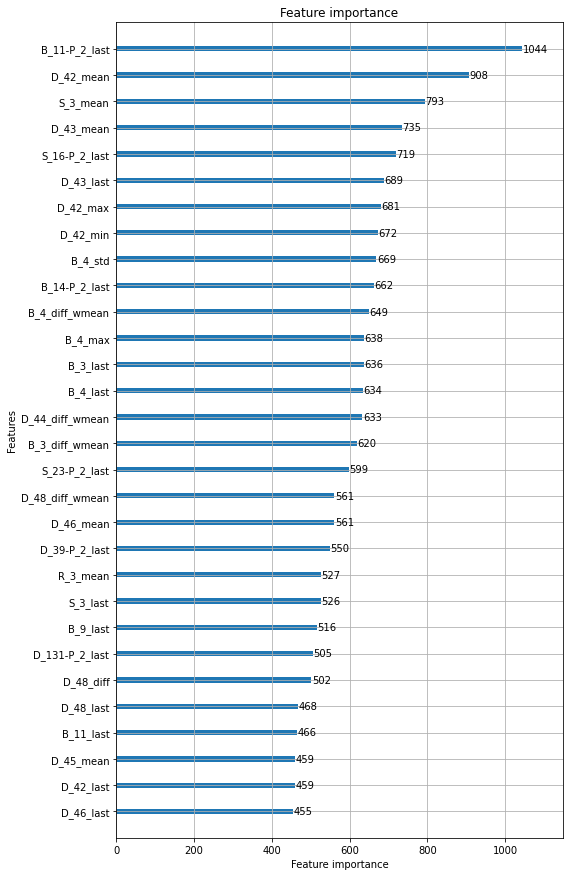

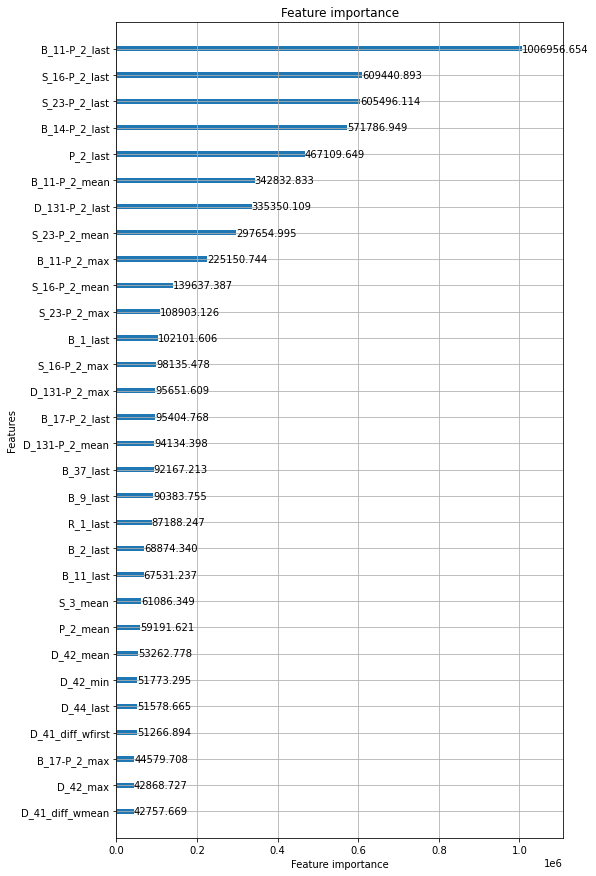

######################################## training model 2/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	valid_0's amex_metric: 0.757708	valid_0's recall_at4: 0.611462	valid_0's norm_gini: 0.903954


[100]	valid_0's amex_metric: 0.764011	valid_0's recall_at4: 0.619372	valid_0's norm_gini: 0.908649


[150]	valid_0's amex_metric: 0.768019	valid_0's recall_at4: 0.625431	valid_0's norm_gini: 0.910606


[200]	valid_0's amex_metric: 0.770203	valid_0's recall_at4: 0.628377	valid_0's norm_gini: 0.912028


[250]	valid_0's amex_metric: 0.773949	valid_0's recall_at4: 0.63431	valid_0's norm_gini: 0.913589


[300]	valid_0's amex_metric: 0.775172	valid_0's recall_at4: 0.635319	valid_0's norm_gini: 0.915025


[350]	valid_0's amex_metric: 0.777904	valid_0's recall_at4: 0.639948	valid_0's norm_gini: 0.915861


[400]	valid_0's amex_metric: 0.778723	valid_0's recall_at4: 0.640916	valid_0's norm_gini: 0.916531


[450]	valid_0's amex_metric: 0.78113	valid_0's recall_at4: 0.644618	valid_0's norm_gini: 0.917641


[500]	valid_0's amex_metric: 0.783818	valid_0's recall_at4: 0.64891	valid_0's norm_gini: 0.918725


[550]	valid_0's amex_metric: 0.786953	valid_0's recall_at4: 0.654296	valid_0's norm_gini: 0.91961


[600]	valid_0's amex_metric: 0.788063	valid_0's recall_at4: 0.655643	valid_0's norm_gini: 0.920483


[650]	valid_0's amex_metric: 0.788357	valid_0's recall_at4: 0.655895	valid_0's norm_gini: 0.920818


[700]	valid_0's amex_metric: 0.789832	valid_0's recall_at4: 0.658335	valid_0's norm_gini: 0.921328


[750]	valid_0's amex_metric: 0.790692	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.92166


[800]	valid_0's amex_metric: 0.790456	valid_0's recall_at4: 0.658967	valid_0's norm_gini: 0.921945


[850]	valid_0's amex_metric: 0.790984	valid_0's recall_at4: 0.659766	valid_0's norm_gini: 0.922202


[900]	valid_0's amex_metric: 0.791462	valid_0's recall_at4: 0.660439	valid_0's norm_gini: 0.922484


[950]	valid_0's amex_metric: 0.792133	valid_0's recall_at4: 0.661491	valid_0's norm_gini: 0.922775


[1000]	valid_0's amex_metric: 0.792045	valid_0's recall_at4: 0.660944	valid_0's norm_gini: 0.923147


[1050]	valid_0's amex_metric: 0.792712	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.923512


[1100]	valid_0's amex_metric: 0.792991	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.923733


[1150]	valid_0's amex_metric: 0.793584	valid_0's recall_at4: 0.663258	valid_0's norm_gini: 0.923909


[1200]	valid_0's amex_metric: 0.794128	valid_0's recall_at4: 0.664226	valid_0's norm_gini: 0.924029


[1250]	valid_0's amex_metric: 0.794755	valid_0's recall_at4: 0.66532	valid_0's norm_gini: 0.92419


[1300]	valid_0's amex_metric: 0.79483	valid_0's recall_at4: 0.665404	valid_0's norm_gini: 0.924255


[1350]	valid_0's amex_metric: 0.795297	valid_0's recall_at4: 0.666246	valid_0's norm_gini: 0.924348


[1400]	valid_0's amex_metric: 0.794892	valid_0's recall_at4: 0.66532	valid_0's norm_gini: 0.924464


[1450]	valid_0's amex_metric: 0.795321	valid_0's recall_at4: 0.666036	valid_0's norm_gini: 0.924606


[1500]	valid_0's amex_metric: 0.795859	valid_0's recall_at4: 0.667003	valid_0's norm_gini: 0.924715


[1550]	valid_0's amex_metric: 0.796502	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.924865


[1600]	valid_0's amex_metric: 0.796495	valid_0's recall_at4: 0.668013	valid_0's norm_gini: 0.924977


[1650]	valid_0's amex_metric: 0.796904	valid_0's recall_at4: 0.66877	valid_0's norm_gini: 0.925037


[1700]	valid_0's amex_metric: 0.796675	valid_0's recall_at4: 0.668266	valid_0's norm_gini: 0.925084


[1750]	valid_0's amex_metric: 0.796901	valid_0's recall_at4: 0.668644	valid_0's norm_gini: 0.925158


[1800]	valid_0's amex_metric: 0.797187	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.925183


[1850]	valid_0's amex_metric: 0.797412	valid_0's recall_at4: 0.669528	valid_0's norm_gini: 0.925296


[1900]	valid_0's amex_metric: 0.798336	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.925293


[1950]	valid_0's amex_metric: 0.797778	valid_0's recall_at4: 0.670201	valid_0's norm_gini: 0.925355


[2000]	valid_0's amex_metric: 0.797604	valid_0's recall_at4: 0.669696	valid_0's norm_gini: 0.925513


[2050]	valid_0's amex_metric: 0.797715	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.925608


[2100]	valid_0's amex_metric: 0.798591	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.925676


[2150]	valid_0's amex_metric: 0.798188	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.925711


[2200]	valid_0's amex_metric: 0.798601	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.925739


[2250]	valid_0's amex_metric: 0.798662	valid_0's recall_at4: 0.67159	valid_0's norm_gini: 0.925733


[2300]	valid_0's amex_metric: 0.798952	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.925767


[2350]	valid_0's amex_metric: 0.799178	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.9258


[2400]	valid_0's amex_metric: 0.799077	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.925807


[2450]	valid_0's amex_metric: 0.798908	valid_0's recall_at4: 0.671968	valid_0's norm_gini: 0.925848


[2500]	valid_0's amex_metric: 0.79873	valid_0's recall_at4: 0.67159	valid_0's norm_gini: 0.925871


[2550]	valid_0's amex_metric: 0.798198	valid_0's recall_at4: 0.670496	valid_0's norm_gini: 0.925901


[2600]	valid_0's amex_metric: 0.798366	valid_0's recall_at4: 0.67079	valid_0's norm_gini: 0.925942


[2650]	valid_0's amex_metric: 0.798368	valid_0's recall_at4: 0.670832	valid_0's norm_gini: 0.925904


[2700]	valid_0's amex_metric: 0.798435	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.925869


[2750]	valid_0's amex_metric: 0.798402	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.925887


[2800]	valid_0's amex_metric: 0.798519	valid_0's recall_at4: 0.671169	valid_0's norm_gini: 0.92587


[2850]	valid_0's amex_metric: 0.798677	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.925891


[2900]	valid_0's amex_metric: 0.799273	valid_0's recall_at4: 0.672642	valid_0's norm_gini: 0.925904


[2950]	valid_0's amex_metric: 0.798841	valid_0's recall_at4: 0.671758	valid_0's norm_gini: 0.925924


[3000]	valid_0's amex_metric: 0.799031	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.925925


[3050]	valid_0's amex_metric: 0.799586	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.925983


[3100]	valid_0's amex_metric: 0.799604	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.926019


[3150]	valid_0's amex_metric: 0.798759	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.926012


[3200]	valid_0's amex_metric: 0.79875	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.926036


[3250]	valid_0's amex_metric: 0.798775	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.926044


[3300]	valid_0's amex_metric: 0.798522	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.926043


[3350]	valid_0's amex_metric: 0.798343	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.926022


[3400]	valid_0's amex_metric: 0.798478	valid_0's recall_at4: 0.670959	valid_0's norm_gini: 0.925998


[3450]	valid_0's amex_metric: 0.79877	valid_0's recall_at4: 0.671548	valid_0's norm_gini: 0.925993


[3500]	valid_0's amex_metric: 0.798801	valid_0's recall_at4: 0.671632	valid_0's norm_gini: 0.925969


[3550]	valid_0's amex_metric: 0.798012	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.92599


[3600]	valid_0's amex_metric: 0.798956	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.926028


[3650]	valid_0's amex_metric: 0.799048	valid_0's recall_at4: 0.672053	valid_0's norm_gini: 0.926043


[3700]	valid_0's amex_metric: 0.798745	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.926027


[3750]	valid_0's amex_metric: 0.798638	valid_0's recall_at4: 0.671253	valid_0's norm_gini: 0.926022


[3800]	valid_0's amex_metric: 0.798758	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.926052


[3850]	valid_0's amex_metric: 0.799005	valid_0's recall_at4: 0.671968	valid_0's norm_gini: 0.926042


[3900]	valid_0's amex_metric: 0.798473	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.926071


[3950]	valid_0's amex_metric: 0.798002	valid_0's recall_at4: 0.669949	valid_0's norm_gini: 0.926056


[4000]	valid_0's amex_metric: 0.797988	valid_0's recall_at4: 0.669907	valid_0's norm_gini: 0.926069


[4050]	valid_0's amex_metric: 0.79838	valid_0's recall_at4: 0.670706	valid_0's norm_gini: 0.926053


[4100]	valid_0's amex_metric: 0.798345	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.926027


[4150]	valid_0's amex_metric: 0.797822	valid_0's recall_at4: 0.669612	valid_0's norm_gini: 0.926033


[4200]	valid_0's amex_metric: 0.797923	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.926023


[4250]	valid_0's amex_metric: 0.798651	valid_0's recall_at4: 0.671253	valid_0's norm_gini: 0.926049


[4300]	valid_0's amex_metric: 0.798751	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.926039


[4350]	valid_0's amex_metric: 0.798581	valid_0's recall_at4: 0.671127	valid_0's norm_gini: 0.926035


[4400]	valid_0's amex_metric: 0.798623	valid_0's recall_at4: 0.671211	valid_0's norm_gini: 0.926035


[4450]	valid_0's amex_metric: 0.798623	valid_0's recall_at4: 0.671211	valid_0's norm_gini: 0.926036


[4500]	valid_0's amex_metric: 0.798738	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.926012


[4550]	valid_0's amex_metric: 0.798541	valid_0's recall_at4: 0.671085	valid_0's norm_gini: 0.925997


[4600]	valid_0's amex_metric: 0.79821	valid_0's recall_at4: 0.670412	valid_0's norm_gini: 0.926009


[4650]	valid_0's amex_metric: 0.798063	valid_0's recall_at4: 0.670117	valid_0's norm_gini: 0.92601


[4700]	valid_0's amex_metric: 0.797916	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.92601


[4750]	valid_0's amex_metric: 0.798228	valid_0's recall_at4: 0.670454	valid_0's norm_gini: 0.926003


[4800]	valid_0's amex_metric: 0.798024	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.926015


[4850]	valid_0's amex_metric: 0.798181	valid_0's recall_at4: 0.670369	valid_0's norm_gini: 0.925992


[4900]	valid_0's amex_metric: 0.798031	valid_0's recall_at4: 0.670075	valid_0's norm_gini: 0.925988


[4950]	valid_0's amex_metric: 0.798638	valid_0's recall_at4: 0.671295	valid_0's norm_gini: 0.92598


[5000]	valid_0's amex_metric: 0.798522	valid_0's recall_at4: 0.671085	valid_0's norm_gini: 0.925959


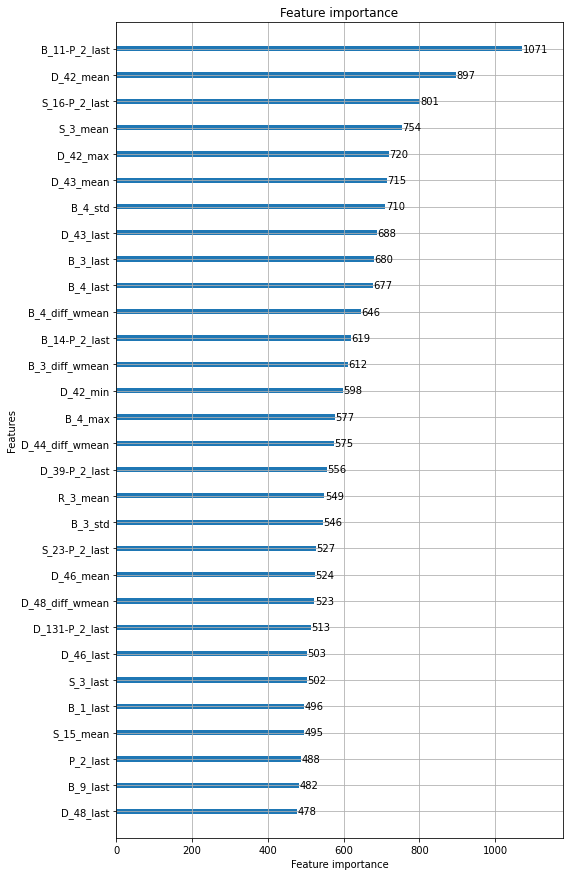

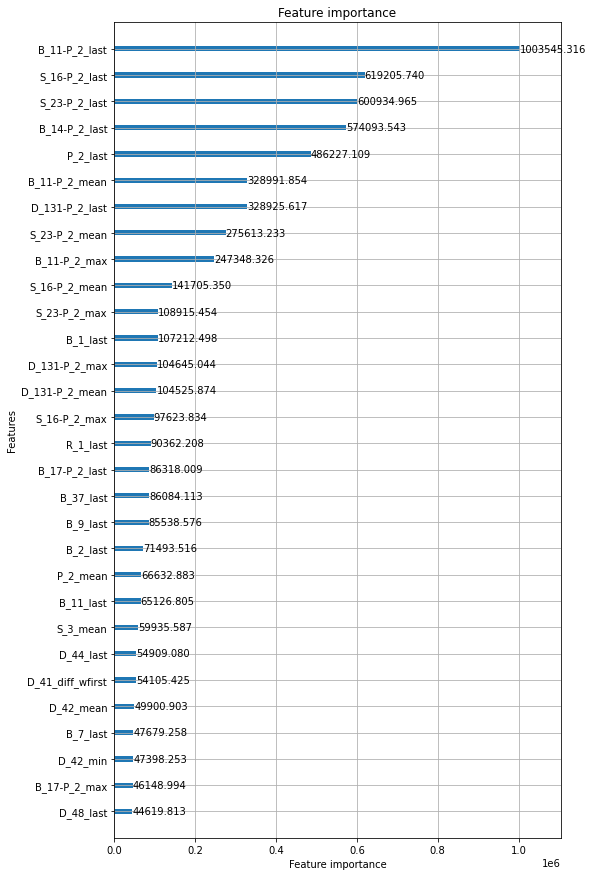

######################################## training model 3/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	valid_0's amex_metric: 0.753922	valid_0's recall_at4: 0.60515	valid_0's norm_gini: 0.902694


[100]	valid_0's amex_metric: 0.759943	valid_0's recall_at4: 0.612177	valid_0's norm_gini: 0.90771


[150]	valid_0's amex_metric: 0.763238	valid_0's recall_at4: 0.616637	valid_0's norm_gini: 0.909839


[200]	valid_0's amex_metric: 0.767045	valid_0's recall_at4: 0.622949	valid_0's norm_gini: 0.911142


[250]	valid_0's amex_metric: 0.770741	valid_0's recall_at4: 0.628755	valid_0's norm_gini: 0.912726


[300]	valid_0's amex_metric: 0.773103	valid_0's recall_at4: 0.632248	valid_0's norm_gini: 0.913958


[350]	valid_0's amex_metric: 0.774356	valid_0's recall_at4: 0.633889	valid_0's norm_gini: 0.914823


[400]	valid_0's amex_metric: 0.775769	valid_0's recall_at4: 0.636161	valid_0's norm_gini: 0.915377


[450]	valid_0's amex_metric: 0.777971	valid_0's recall_at4: 0.639485	valid_0's norm_gini: 0.916457


[500]	valid_0's amex_metric: 0.780209	valid_0's recall_at4: 0.642893	valid_0's norm_gini: 0.917525


[550]	valid_0's amex_metric: 0.781646	valid_0's recall_at4: 0.644913	valid_0's norm_gini: 0.918379


[600]	valid_0's amex_metric: 0.783211	valid_0's recall_at4: 0.647185	valid_0's norm_gini: 0.919238


[650]	valid_0's amex_metric: 0.784069	valid_0's recall_at4: 0.648531	valid_0's norm_gini: 0.919606


[700]	valid_0's amex_metric: 0.784654	valid_0's recall_at4: 0.649205	valid_0's norm_gini: 0.920104


[750]	valid_0's amex_metric: 0.78546	valid_0's recall_at4: 0.650509	valid_0's norm_gini: 0.920411


[800]	valid_0's amex_metric: 0.785845	valid_0's recall_at4: 0.651014	valid_0's norm_gini: 0.920676


[850]	valid_0's amex_metric: 0.787242	valid_0's recall_at4: 0.653497	valid_0's norm_gini: 0.920987


[900]	valid_0's amex_metric: 0.787708	valid_0's recall_at4: 0.654212	valid_0's norm_gini: 0.921205


[950]	valid_0's amex_metric: 0.788066	valid_0's recall_at4: 0.654591	valid_0's norm_gini: 0.921541


[1000]	valid_0's amex_metric: 0.789078	valid_0's recall_at4: 0.656358	valid_0's norm_gini: 0.921797


[1050]	valid_0's amex_metric: 0.789665	valid_0's recall_at4: 0.657199	valid_0's norm_gini: 0.92213


[1100]	valid_0's amex_metric: 0.790263	valid_0's recall_at4: 0.658209	valid_0's norm_gini: 0.922317


[1150]	valid_0's amex_metric: 0.789923	valid_0's recall_at4: 0.657368	valid_0's norm_gini: 0.922478


[1200]	valid_0's amex_metric: 0.790273	valid_0's recall_at4: 0.657957	valid_0's norm_gini: 0.922589


[1250]	valid_0's amex_metric: 0.790417	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.922793


[1300]	valid_0's amex_metric: 0.790406	valid_0's recall_at4: 0.657957	valid_0's norm_gini: 0.922855


[1350]	valid_0's amex_metric: 0.790553	valid_0's recall_at4: 0.658125	valid_0's norm_gini: 0.922981


[1400]	valid_0's amex_metric: 0.790372	valid_0's recall_at4: 0.657662	valid_0's norm_gini: 0.923082


[1450]	valid_0's amex_metric: 0.791032	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.923183


[1500]	valid_0's amex_metric: 0.791083	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.923284


[1550]	valid_0's amex_metric: 0.791134	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.923387


[1600]	valid_0's amex_metric: 0.790999	valid_0's recall_at4: 0.658504	valid_0's norm_gini: 0.923494


[1650]	valid_0's amex_metric: 0.791224	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.923565


[1700]	valid_0's amex_metric: 0.791062	valid_0's recall_at4: 0.658504	valid_0's norm_gini: 0.923621


[1750]	valid_0's amex_metric: 0.791347	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.923684


[1800]	valid_0's amex_metric: 0.790535	valid_0's recall_at4: 0.657368	valid_0's norm_gini: 0.923702


[1850]	valid_0's amex_metric: 0.791028	valid_0's recall_at4: 0.658293	valid_0's norm_gini: 0.923762


[1900]	valid_0's amex_metric: 0.79097	valid_0's recall_at4: 0.658167	valid_0's norm_gini: 0.923772


[1950]	valid_0's amex_metric: 0.791159	valid_0's recall_at4: 0.658504	valid_0's norm_gini: 0.923815


[2000]	valid_0's amex_metric: 0.790853	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.923918


[2050]	valid_0's amex_metric: 0.791878	valid_0's recall_at4: 0.659766	valid_0's norm_gini: 0.92399


[2100]	valid_0's amex_metric: 0.791516	valid_0's recall_at4: 0.658967	valid_0's norm_gini: 0.924066


[2150]	valid_0's amex_metric: 0.791719	valid_0's recall_at4: 0.659303	valid_0's norm_gini: 0.924134


[2200]	valid_0's amex_metric: 0.79131	valid_0's recall_at4: 0.65842	valid_0's norm_gini: 0.9242


[2250]	valid_0's amex_metric: 0.791143	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.924245


[2300]	valid_0's amex_metric: 0.791649	valid_0's recall_at4: 0.659051	valid_0's norm_gini: 0.924247


[2350]	valid_0's amex_metric: 0.792041	valid_0's recall_at4: 0.659808	valid_0's norm_gini: 0.924274


[2400]	valid_0's amex_metric: 0.791994	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.924306


[2450]	valid_0's amex_metric: 0.791988	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.924295


[2500]	valid_0's amex_metric: 0.791592	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.924301


[2550]	valid_0's amex_metric: 0.791354	valid_0's recall_at4: 0.658378	valid_0's norm_gini: 0.92433


[2600]	valid_0's amex_metric: 0.791885	valid_0's recall_at4: 0.659429	valid_0's norm_gini: 0.924341


[2650]	valid_0's amex_metric: 0.790882	valid_0's recall_at4: 0.657452	valid_0's norm_gini: 0.924313


[2700]	valid_0's amex_metric: 0.791017	valid_0's recall_at4: 0.657704	valid_0's norm_gini: 0.924329


[2750]	valid_0's amex_metric: 0.790896	valid_0's recall_at4: 0.657452	valid_0's norm_gini: 0.924341


[2800]	valid_0's amex_metric: 0.790779	valid_0's recall_at4: 0.657199	valid_0's norm_gini: 0.924359


[2850]	valid_0's amex_metric: 0.791171	valid_0's recall_at4: 0.657999	valid_0's norm_gini: 0.924343


[2900]	valid_0's amex_metric: 0.791456	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.924365


[2950]	valid_0's amex_metric: 0.791253	valid_0's recall_at4: 0.658167	valid_0's norm_gini: 0.924338


[3000]	valid_0's amex_metric: 0.792038	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.924352


[3050]	valid_0's amex_metric: 0.791871	valid_0's recall_at4: 0.659387	valid_0's norm_gini: 0.924354


[3100]	valid_0's amex_metric: 0.791193	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.924345


[3150]	valid_0's amex_metric: 0.792055	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.924387


[3200]	valid_0's amex_metric: 0.792165	valid_0's recall_at4: 0.659976	valid_0's norm_gini: 0.924353


[3250]	valid_0's amex_metric: 0.791671	valid_0's recall_at4: 0.658967	valid_0's norm_gini: 0.924375


[3300]	valid_0's amex_metric: 0.791517	valid_0's recall_at4: 0.658714	valid_0's norm_gini: 0.92432


[3350]	valid_0's amex_metric: 0.791572	valid_0's recall_at4: 0.658798	valid_0's norm_gini: 0.924347


[3400]	valid_0's amex_metric: 0.792049	valid_0's recall_at4: 0.659766	valid_0's norm_gini: 0.924333


[3450]	valid_0's amex_metric: 0.791373	valid_0's recall_at4: 0.658378	valid_0's norm_gini: 0.924369


[3500]	valid_0's amex_metric: 0.79224	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.924377


[3550]	valid_0's amex_metric: 0.792272	valid_0's recall_at4: 0.660187	valid_0's norm_gini: 0.924357


[3600]	valid_0's amex_metric: 0.792001	valid_0's recall_at4: 0.65964	valid_0's norm_gini: 0.924362


[3650]	valid_0's amex_metric: 0.79249	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.924415


[3700]	valid_0's amex_metric: 0.792355	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.924397


[3750]	valid_0's amex_metric: 0.792311	valid_0's recall_at4: 0.660229	valid_0's norm_gini: 0.924394


[3800]	valid_0's amex_metric: 0.792492	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.924376


[3850]	valid_0's amex_metric: 0.793239	valid_0's recall_at4: 0.66208	valid_0's norm_gini: 0.924398


[3900]	valid_0's amex_metric: 0.792912	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.924416


[3950]	valid_0's amex_metric: 0.792603	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.92443


[4000]	valid_0's amex_metric: 0.79275	valid_0's recall_at4: 0.66107	valid_0's norm_gini: 0.92443


[4050]	valid_0's amex_metric: 0.792503	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.924441


[4100]	valid_0's amex_metric: 0.79222	valid_0's recall_at4: 0.660019	valid_0's norm_gini: 0.924422


[4150]	valid_0's amex_metric: 0.792625	valid_0's recall_at4: 0.660818	valid_0's norm_gini: 0.924431


[4200]	valid_0's amex_metric: 0.792903	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.924442


[4250]	valid_0's amex_metric: 0.792732	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.924436


[4300]	valid_0's amex_metric: 0.792685	valid_0's recall_at4: 0.660944	valid_0's norm_gini: 0.924427


[4350]	valid_0's amex_metric: 0.792314	valid_0's recall_at4: 0.660187	valid_0's norm_gini: 0.924441


[4400]	valid_0's amex_metric: 0.792201	valid_0's recall_at4: 0.659976	valid_0's norm_gini: 0.924426


[4450]	valid_0's amex_metric: 0.79179	valid_0's recall_at4: 0.659135	valid_0's norm_gini: 0.924446


[4500]	valid_0's amex_metric: 0.792057	valid_0's recall_at4: 0.65964	valid_0's norm_gini: 0.924474


[4550]	valid_0's amex_metric: 0.791669	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.924456


[4600]	valid_0's amex_metric: 0.792208	valid_0's recall_at4: 0.659976	valid_0's norm_gini: 0.924439


[4650]	valid_0's amex_metric: 0.792511	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.924415


[4700]	valid_0's amex_metric: 0.792473	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.924422


[4750]	valid_0's amex_metric: 0.792436	valid_0's recall_at4: 0.660439	valid_0's norm_gini: 0.924433


[4800]	valid_0's amex_metric: 0.792577	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.92442


[4850]	valid_0's amex_metric: 0.79239	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.924383


[4900]	valid_0's amex_metric: 0.792238	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.924373


[4950]	valid_0's amex_metric: 0.791933	valid_0's recall_at4: 0.659514	valid_0's norm_gini: 0.924352


[5000]	valid_0's amex_metric: 0.792099	valid_0's recall_at4: 0.659892	valid_0's norm_gini: 0.924306


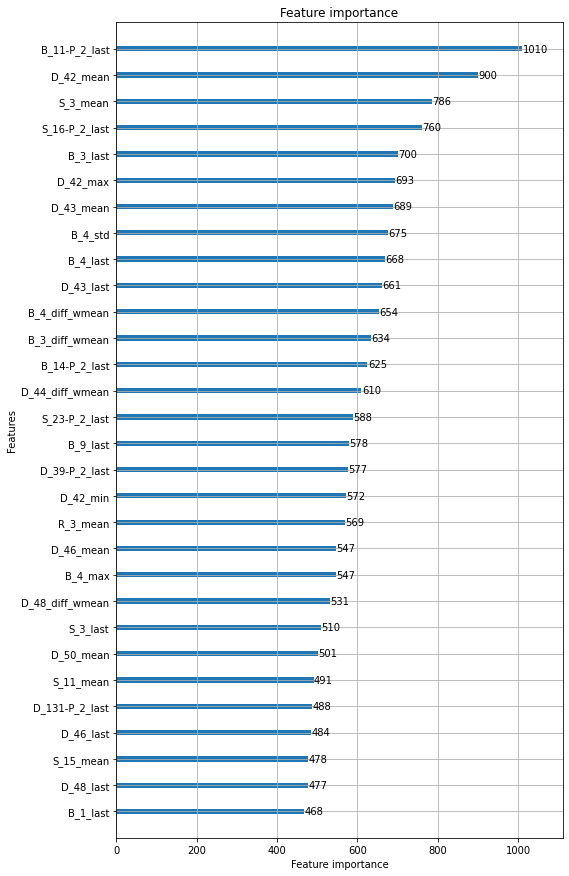

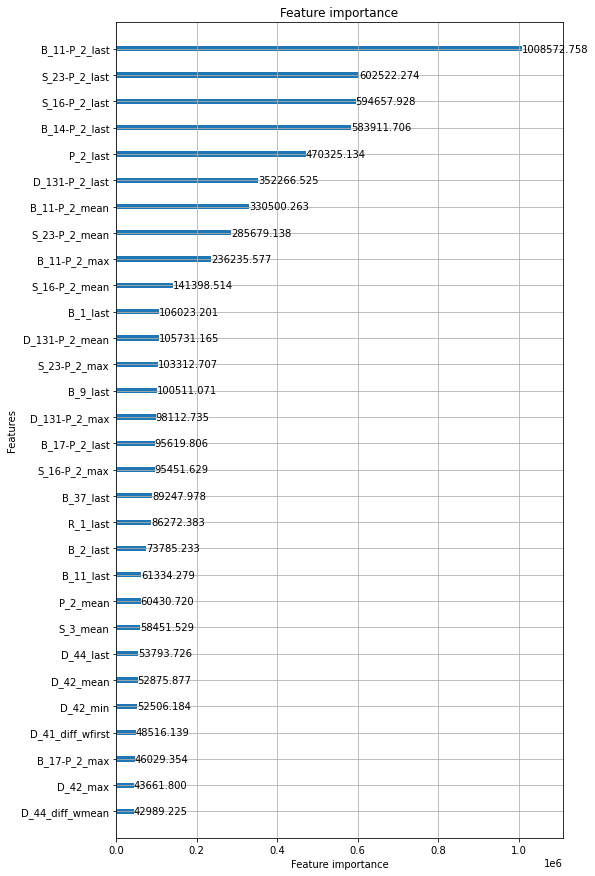

######################################## training model 4/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	valid_0's amex_metric: 0.75374	valid_0's recall_at4: 0.605302	valid_0's norm_gini: 0.902179


[100]	valid_0's amex_metric: 0.762187	valid_0's recall_at4: 0.617084	valid_0's norm_gini: 0.907291


[150]	valid_0's amex_metric: 0.766382	valid_0's recall_at4: 0.623354	valid_0's norm_gini: 0.90941


[200]	valid_0's amex_metric: 0.76845	valid_0's recall_at4: 0.626089	valid_0's norm_gini: 0.910812


[250]	valid_0's amex_metric: 0.770202	valid_0's recall_at4: 0.628109	valid_0's norm_gini: 0.912296


[300]	valid_0's amex_metric: 0.772897	valid_0's recall_at4: 0.632022	valid_0's norm_gini: 0.913773


[350]	valid_0's amex_metric: 0.77511	valid_0's recall_at4: 0.635472	valid_0's norm_gini: 0.914748


[400]	valid_0's amex_metric: 0.775314	valid_0's recall_at4: 0.635178	valid_0's norm_gini: 0.91545


[450]	valid_0's amex_metric: 0.776807	valid_0's recall_at4: 0.637113	valid_0's norm_gini: 0.916501


[500]	valid_0's amex_metric: 0.778943	valid_0's recall_at4: 0.640269	valid_0's norm_gini: 0.917617


[550]	valid_0's amex_metric: 0.78075	valid_0's recall_at4: 0.642962	valid_0's norm_gini: 0.918537


[600]	valid_0's amex_metric: 0.78303	valid_0's recall_at4: 0.646623	valid_0's norm_gini: 0.919436


[650]	valid_0's amex_metric: 0.783494	valid_0's recall_at4: 0.647128	valid_0's norm_gini: 0.91986


[700]	valid_0's amex_metric: 0.783951	valid_0's recall_at4: 0.647549	valid_0's norm_gini: 0.920352


[750]	valid_0's amex_metric: 0.784026	valid_0's recall_at4: 0.647423	valid_0's norm_gini: 0.92063


[800]	valid_0's amex_metric: 0.785059	valid_0's recall_at4: 0.649106	valid_0's norm_gini: 0.921012


[850]	valid_0's amex_metric: 0.786211	valid_0's recall_at4: 0.65121	valid_0's norm_gini: 0.921212


[900]	valid_0's amex_metric: 0.785872	valid_0's recall_at4: 0.650284	valid_0's norm_gini: 0.92146


[950]	valid_0's amex_metric: 0.786775	valid_0's recall_at4: 0.651757	valid_0's norm_gini: 0.921793


[1000]	valid_0's amex_metric: 0.787427	valid_0's recall_at4: 0.652767	valid_0's norm_gini: 0.922087


[1050]	valid_0's amex_metric: 0.787926	valid_0's recall_at4: 0.653482	valid_0's norm_gini: 0.922371


[1100]	valid_0's amex_metric: 0.788453	valid_0's recall_at4: 0.654281	valid_0's norm_gini: 0.922624


[1150]	valid_0's amex_metric: 0.788086	valid_0's recall_at4: 0.653356	valid_0's norm_gini: 0.922815


[1200]	valid_0's amex_metric: 0.788978	valid_0's recall_at4: 0.654997	valid_0's norm_gini: 0.922959


[1250]	valid_0's amex_metric: 0.788912	valid_0's recall_at4: 0.654702	valid_0's norm_gini: 0.923122


[1300]	valid_0's amex_metric: 0.788519	valid_0's recall_at4: 0.653861	valid_0's norm_gini: 0.923177


[1350]	valid_0's amex_metric: 0.788908	valid_0's recall_at4: 0.654534	valid_0's norm_gini: 0.923282


[1400]	valid_0's amex_metric: 0.789831	valid_0's recall_at4: 0.656217	valid_0's norm_gini: 0.923444


[1450]	valid_0's amex_metric: 0.789814	valid_0's recall_at4: 0.656049	valid_0's norm_gini: 0.92358


[1500]	valid_0's amex_metric: 0.790377	valid_0's recall_at4: 0.657059	valid_0's norm_gini: 0.923696


[1550]	valid_0's amex_metric: 0.790167	valid_0's recall_at4: 0.656512	valid_0's norm_gini: 0.923823


[1600]	valid_0's amex_metric: 0.790472	valid_0's recall_at4: 0.657017	valid_0's norm_gini: 0.923926


[1650]	valid_0's amex_metric: 0.791049	valid_0's recall_at4: 0.658069	valid_0's norm_gini: 0.924029


[1700]	valid_0's amex_metric: 0.790403	valid_0's recall_at4: 0.656722	valid_0's norm_gini: 0.924084


[1750]	valid_0's amex_metric: 0.79124	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.9242


[1800]	valid_0's amex_metric: 0.791535	valid_0's recall_at4: 0.658826	valid_0's norm_gini: 0.924244


[1850]	valid_0's amex_metric: 0.791559	valid_0's recall_at4: 0.658784	valid_0's norm_gini: 0.924335


[1900]	valid_0's amex_metric: 0.791568	valid_0's recall_at4: 0.658784	valid_0's norm_gini: 0.924351


[1950]	valid_0's amex_metric: 0.791309	valid_0's recall_at4: 0.658237	valid_0's norm_gini: 0.924381


[2000]	valid_0's amex_metric: 0.791233	valid_0's recall_at4: 0.657984	valid_0's norm_gini: 0.924481


[2050]	valid_0's amex_metric: 0.791289	valid_0's recall_at4: 0.658027	valid_0's norm_gini: 0.924552


[2100]	valid_0's amex_metric: 0.791708	valid_0's recall_at4: 0.658784	valid_0's norm_gini: 0.924632


[2150]	valid_0's amex_metric: 0.791666	valid_0's recall_at4: 0.658616	valid_0's norm_gini: 0.924716


[2200]	valid_0's amex_metric: 0.791105	valid_0's recall_at4: 0.657437	valid_0's norm_gini: 0.924773


[2250]	valid_0's amex_metric: 0.791862	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.924815


[2300]	valid_0's amex_metric: 0.791964	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.924807


[2350]	valid_0's amex_metric: 0.792304	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.924856


[2400]	valid_0's amex_metric: 0.791827	valid_0's recall_at4: 0.658742	valid_0's norm_gini: 0.924911


[2450]	valid_0's amex_metric: 0.791148	valid_0's recall_at4: 0.657353	valid_0's norm_gini: 0.924943


[2500]	valid_0's amex_metric: 0.791513	valid_0's recall_at4: 0.658069	valid_0's norm_gini: 0.924958


[2550]	valid_0's amex_metric: 0.791354	valid_0's recall_at4: 0.657732	valid_0's norm_gini: 0.924976


[2600]	valid_0's amex_metric: 0.791861	valid_0's recall_at4: 0.658742	valid_0's norm_gini: 0.924981


[2650]	valid_0's amex_metric: 0.791793	valid_0's recall_at4: 0.658531	valid_0's norm_gini: 0.925054


[2700]	valid_0's amex_metric: 0.792105	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.925089


[2750]	valid_0's amex_metric: 0.792028	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.925145


[2800]	valid_0's amex_metric: 0.791928	valid_0's recall_at4: 0.6587	valid_0's norm_gini: 0.925155


[2850]	valid_0's amex_metric: 0.792265	valid_0's recall_at4: 0.659373	valid_0's norm_gini: 0.925157


[2900]	valid_0's amex_metric: 0.791618	valid_0's recall_at4: 0.658069	valid_0's norm_gini: 0.925167


[2950]	valid_0's amex_metric: 0.791892	valid_0's recall_at4: 0.658616	valid_0's norm_gini: 0.925168


[3000]	valid_0's amex_metric: 0.792328	valid_0's recall_at4: 0.659457	valid_0's norm_gini: 0.925199


[3050]	valid_0's amex_metric: 0.792342	valid_0's recall_at4: 0.659499	valid_0's norm_gini: 0.925186


[3100]	valid_0's amex_metric: 0.792037	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.925164


[3150]	valid_0's amex_metric: 0.791747	valid_0's recall_at4: 0.658321	valid_0's norm_gini: 0.925172


[3200]	valid_0's amex_metric: 0.791224	valid_0's recall_at4: 0.657227	valid_0's norm_gini: 0.925221


[3250]	valid_0's amex_metric: 0.79121	valid_0's recall_at4: 0.657185	valid_0's norm_gini: 0.925236


[3300]	valid_0's amex_metric: 0.790942	valid_0's recall_at4: 0.656638	valid_0's norm_gini: 0.925246


[3350]	valid_0's amex_metric: 0.791551	valid_0's recall_at4: 0.657858	valid_0's norm_gini: 0.925244


[3400]	valid_0's amex_metric: 0.791481	valid_0's recall_at4: 0.657732	valid_0's norm_gini: 0.925229


[3450]	valid_0's amex_metric: 0.791565	valid_0's recall_at4: 0.6579	valid_0's norm_gini: 0.925229


[3500]	valid_0's amex_metric: 0.792066	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.925222


[3550]	valid_0's amex_metric: 0.792012	valid_0's recall_at4: 0.658784	valid_0's norm_gini: 0.92524


[3600]	valid_0's amex_metric: 0.792044	valid_0's recall_at4: 0.658868	valid_0's norm_gini: 0.92522


[3650]	valid_0's amex_metric: 0.791328	valid_0's recall_at4: 0.657437	valid_0's norm_gini: 0.925219


[3700]	valid_0's amex_metric: 0.791098	valid_0's recall_at4: 0.656975	valid_0's norm_gini: 0.925222


[3750]	valid_0's amex_metric: 0.791995	valid_0's recall_at4: 0.658784	valid_0's norm_gini: 0.925207


[3800]	valid_0's amex_metric: 0.792491	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.925231


[3850]	valid_0's amex_metric: 0.792502	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.925252


[3900]	valid_0's amex_metric: 0.792696	valid_0's recall_at4: 0.66013	valid_0's norm_gini: 0.925261


[3950]	valid_0's amex_metric: 0.792716	valid_0's recall_at4: 0.660173	valid_0's norm_gini: 0.925259


[4000]	valid_0's amex_metric: 0.79256	valid_0's recall_at4: 0.659836	valid_0's norm_gini: 0.925283


[4050]	valid_0's amex_metric: 0.792876	valid_0's recall_at4: 0.660467	valid_0's norm_gini: 0.925285


[4100]	valid_0's amex_metric: 0.792895	valid_0's recall_at4: 0.660509	valid_0's norm_gini: 0.925281


[4150]	valid_0's amex_metric: 0.792875	valid_0's recall_at4: 0.660467	valid_0's norm_gini: 0.925282


[4200]	valid_0's amex_metric: 0.792937	valid_0's recall_at4: 0.660593	valid_0's norm_gini: 0.92528


[4250]	valid_0's amex_metric: 0.792624	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.925285


[4300]	valid_0's amex_metric: 0.792405	valid_0's recall_at4: 0.659541	valid_0's norm_gini: 0.925268


[4350]	valid_0's amex_metric: 0.792535	valid_0's recall_at4: 0.659794	valid_0's norm_gini: 0.925276


[4400]	valid_0's amex_metric: 0.79288	valid_0's recall_at4: 0.660467	valid_0's norm_gini: 0.925293


[4450]	valid_0's amex_metric: 0.793025	valid_0's recall_at4: 0.660762	valid_0's norm_gini: 0.925289


[4500]	valid_0's amex_metric: 0.79308	valid_0's recall_at4: 0.660888	valid_0's norm_gini: 0.925272


[4550]	valid_0's amex_metric: 0.792936	valid_0's recall_at4: 0.660593	valid_0's norm_gini: 0.925279


[4600]	valid_0's amex_metric: 0.792764	valid_0's recall_at4: 0.660257	valid_0's norm_gini: 0.925271


[4650]	valid_0's amex_metric: 0.792889	valid_0's recall_at4: 0.660509	valid_0's norm_gini: 0.925268


[4700]	valid_0's amex_metric: 0.792899	valid_0's recall_at4: 0.660551	valid_0's norm_gini: 0.925246


[4750]	valid_0's amex_metric: 0.79266	valid_0's recall_at4: 0.660088	valid_0's norm_gini: 0.925231


[4800]	valid_0's amex_metric: 0.792548	valid_0's recall_at4: 0.659878	valid_0's norm_gini: 0.925218


[4850]	valid_0's amex_metric: 0.792764	valid_0's recall_at4: 0.660299	valid_0's norm_gini: 0.925229


[4900]	valid_0's amex_metric: 0.793133	valid_0's recall_at4: 0.661056	valid_0's norm_gini: 0.92521


[4950]	valid_0's amex_metric: 0.793321	valid_0's recall_at4: 0.661435	valid_0's norm_gini: 0.925208


[5000]	valid_0's amex_metric: 0.793267	valid_0's recall_at4: 0.661309	valid_0's norm_gini: 0.925224


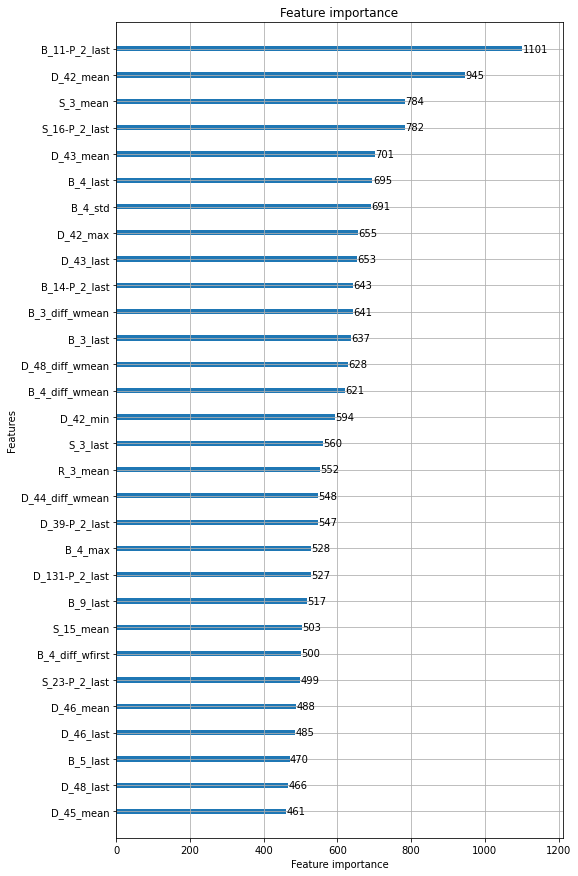

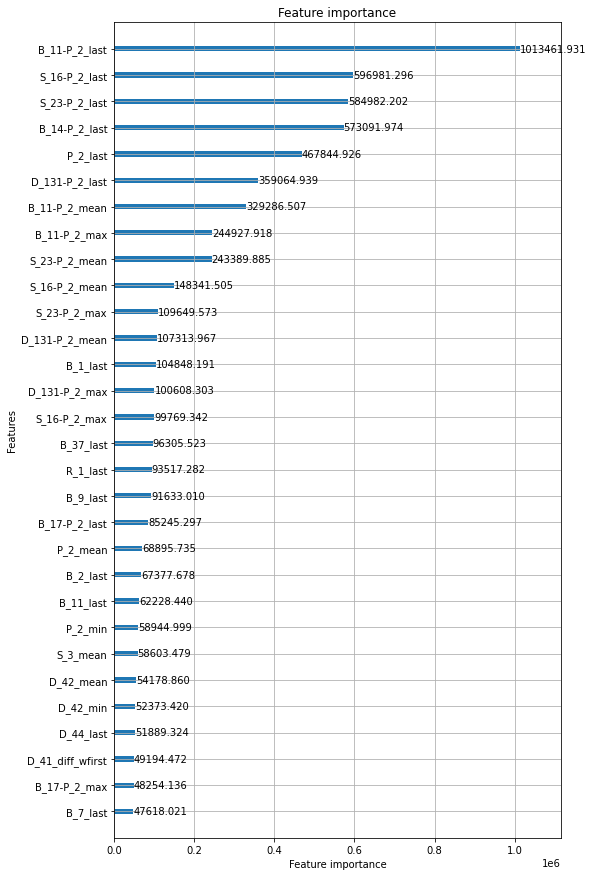

######################################## training model 5/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	valid_0's amex_metric: 0.762109	valid_0's recall_at4: 0.617841	valid_0's norm_gini: 0.906377


[100]	valid_0's amex_metric: 0.770239	valid_0's recall_at4: 0.629455	valid_0's norm_gini: 0.911022


[150]	valid_0's amex_metric: 0.773418	valid_0's recall_at4: 0.633663	valid_0's norm_gini: 0.913172


[200]	valid_0's amex_metric: 0.775571	valid_0's recall_at4: 0.636693	valid_0's norm_gini: 0.914449


[250]	valid_0's amex_metric: 0.778631	valid_0's recall_at4: 0.641111	valid_0's norm_gini: 0.916152


[300]	valid_0's amex_metric: 0.781587	valid_0's recall_at4: 0.645697	valid_0's norm_gini: 0.917476


[350]	valid_0's amex_metric: 0.783955	valid_0's recall_at4: 0.649442	valid_0's norm_gini: 0.918467


[400]	valid_0's amex_metric: 0.784719	valid_0's recall_at4: 0.650368	valid_0's norm_gini: 0.91907


[450]	valid_0's amex_metric: 0.78681	valid_0's recall_at4: 0.653566	valid_0's norm_gini: 0.920055


[500]	valid_0's amex_metric: 0.787886	valid_0's recall_at4: 0.654534	valid_0's norm_gini: 0.921238


[550]	valid_0's amex_metric: 0.790238	valid_0's recall_at4: 0.658405	valid_0's norm_gini: 0.922071


[600]	valid_0's amex_metric: 0.791226	valid_0's recall_at4: 0.659541	valid_0's norm_gini: 0.92291


[650]	valid_0's amex_metric: 0.792149	valid_0's recall_at4: 0.661014	valid_0's norm_gini: 0.923284


[700]	valid_0's amex_metric: 0.79339	valid_0's recall_at4: 0.663034	valid_0's norm_gini: 0.923746


[750]	valid_0's amex_metric: 0.793078	valid_0's recall_at4: 0.66215	valid_0's norm_gini: 0.924006


[800]	valid_0's amex_metric: 0.793926	valid_0's recall_at4: 0.663539	valid_0's norm_gini: 0.924314


[850]	valid_0's amex_metric: 0.794406	valid_0's recall_at4: 0.664296	valid_0's norm_gini: 0.924515


[900]	valid_0's amex_metric: 0.794959	valid_0's recall_at4: 0.66518	valid_0's norm_gini: 0.924737


[950]	valid_0's amex_metric: 0.796344	valid_0's recall_at4: 0.667578	valid_0's norm_gini: 0.925111


[1000]	valid_0's amex_metric: 0.79617	valid_0's recall_at4: 0.666947	valid_0's norm_gini: 0.925392


[1050]	valid_0's amex_metric: 0.796799	valid_0's recall_at4: 0.667915	valid_0's norm_gini: 0.925683


[1100]	valid_0's amex_metric: 0.797129	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.92588


[1150]	valid_0's amex_metric: 0.797813	valid_0's recall_at4: 0.669598	valid_0's norm_gini: 0.926028


[1200]	valid_0's amex_metric: 0.798651	valid_0's recall_at4: 0.671155	valid_0's norm_gini: 0.926147


[1250]	valid_0's amex_metric: 0.798669	valid_0's recall_at4: 0.671029	valid_0's norm_gini: 0.926309


[1300]	valid_0's amex_metric: 0.798953	valid_0's recall_at4: 0.671576	valid_0's norm_gini: 0.92633


[1350]	valid_0's amex_metric: 0.798817	valid_0's recall_at4: 0.671197	valid_0's norm_gini: 0.926436


[1400]	valid_0's amex_metric: 0.798962	valid_0's recall_at4: 0.671365	valid_0's norm_gini: 0.926558


[1450]	valid_0's amex_metric: 0.799402	valid_0's recall_at4: 0.672123	valid_0's norm_gini: 0.926681


[1500]	valid_0's amex_metric: 0.799042	valid_0's recall_at4: 0.671365	valid_0's norm_gini: 0.926718


[1550]	valid_0's amex_metric: 0.799316	valid_0's recall_at4: 0.671744	valid_0's norm_gini: 0.926887


[1600]	valid_0's amex_metric: 0.799875	valid_0's recall_at4: 0.672712	valid_0's norm_gini: 0.927038


[1650]	valid_0's amex_metric: 0.801038	valid_0's recall_at4: 0.674942	valid_0's norm_gini: 0.927134


[1700]	valid_0's amex_metric: 0.800598	valid_0's recall_at4: 0.674016	valid_0's norm_gini: 0.927179


[1750]	valid_0's amex_metric: 0.800598	valid_0's recall_at4: 0.673974	valid_0's norm_gini: 0.927222


[1800]	valid_0's amex_metric: 0.800583	valid_0's recall_at4: 0.67389	valid_0's norm_gini: 0.927277


[1850]	valid_0's amex_metric: 0.801203	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.927296


[1900]	valid_0's amex_metric: 0.801358	valid_0's recall_at4: 0.675405	valid_0's norm_gini: 0.927311


[1950]	valid_0's amex_metric: 0.801639	valid_0's recall_at4: 0.67591	valid_0's norm_gini: 0.927368


[2000]	valid_0's amex_metric: 0.801789	valid_0's recall_at4: 0.67612	valid_0's norm_gini: 0.927457


[2050]	valid_0's amex_metric: 0.801311	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.927512


[2100]	valid_0's amex_metric: 0.801694	valid_0's recall_at4: 0.675826	valid_0's norm_gini: 0.927562


[2150]	valid_0's amex_metric: 0.802314	valid_0's recall_at4: 0.677046	valid_0's norm_gini: 0.927582


[2200]	valid_0's amex_metric: 0.802825	valid_0's recall_at4: 0.678014	valid_0's norm_gini: 0.927636


[2250]	valid_0's amex_metric: 0.802591	valid_0's recall_at4: 0.677509	valid_0's norm_gini: 0.927672


[2300]	valid_0's amex_metric: 0.802864	valid_0's recall_at4: 0.678098	valid_0's norm_gini: 0.92763


[2350]	valid_0's amex_metric: 0.802856	valid_0's recall_at4: 0.678056	valid_0's norm_gini: 0.927656


[2400]	valid_0's amex_metric: 0.802407	valid_0's recall_at4: 0.67713	valid_0's norm_gini: 0.927683


[2450]	valid_0's amex_metric: 0.802315	valid_0's recall_at4: 0.67692	valid_0's norm_gini: 0.92771


[2500]	valid_0's amex_metric: 0.802315	valid_0's recall_at4: 0.676878	valid_0's norm_gini: 0.927752


[2550]	valid_0's amex_metric: 0.802042	valid_0's recall_at4: 0.676331	valid_0's norm_gini: 0.927753


[2600]	valid_0's amex_metric: 0.802612	valid_0's recall_at4: 0.677425	valid_0's norm_gini: 0.9278


[2650]	valid_0's amex_metric: 0.803078	valid_0's recall_at4: 0.678351	valid_0's norm_gini: 0.927806


[2700]	valid_0's amex_metric: 0.802912	valid_0's recall_at4: 0.678014	valid_0's norm_gini: 0.92781


[2750]	valid_0's amex_metric: 0.803115	valid_0's recall_at4: 0.678393	valid_0's norm_gini: 0.927837


[2800]	valid_0's amex_metric: 0.802934	valid_0's recall_at4: 0.678056	valid_0's norm_gini: 0.927812


[2850]	valid_0's amex_metric: 0.802628	valid_0's recall_at4: 0.677425	valid_0's norm_gini: 0.927831


[2900]	valid_0's amex_metric: 0.802812	valid_0's recall_at4: 0.677804	valid_0's norm_gini: 0.92782


[2950]	valid_0's amex_metric: 0.802631	valid_0's recall_at4: 0.677467	valid_0's norm_gini: 0.927794


[3000]	valid_0's amex_metric: 0.802604	valid_0's recall_at4: 0.677425	valid_0's norm_gini: 0.927782


[3050]	valid_0's amex_metric: 0.803115	valid_0's recall_at4: 0.678477	valid_0's norm_gini: 0.927753


[3100]	valid_0's amex_metric: 0.80254	valid_0's recall_at4: 0.677299	valid_0's norm_gini: 0.927781


[3150]	valid_0's amex_metric: 0.802921	valid_0's recall_at4: 0.678056	valid_0's norm_gini: 0.927786


[3200]	valid_0's amex_metric: 0.802687	valid_0's recall_at4: 0.677593	valid_0's norm_gini: 0.927781


[3250]	valid_0's amex_metric: 0.802454	valid_0's recall_at4: 0.67713	valid_0's norm_gini: 0.927779


[3300]	valid_0's amex_metric: 0.802184	valid_0's recall_at4: 0.676583	valid_0's norm_gini: 0.927785


[3350]	valid_0's amex_metric: 0.801396	valid_0's recall_at4: 0.675026	valid_0's norm_gini: 0.927765


[3400]	valid_0's amex_metric: 0.802348	valid_0's recall_at4: 0.67692	valid_0's norm_gini: 0.927777


[3450]	valid_0's amex_metric: 0.802124	valid_0's recall_at4: 0.676457	valid_0's norm_gini: 0.927791


[3500]	valid_0's amex_metric: 0.802087	valid_0's recall_at4: 0.676415	valid_0's norm_gini: 0.927759


[3550]	valid_0's amex_metric: 0.801531	valid_0's recall_at4: 0.675321	valid_0's norm_gini: 0.927742


[3600]	valid_0's amex_metric: 0.802101	valid_0's recall_at4: 0.676457	valid_0's norm_gini: 0.927744


[3650]	valid_0's amex_metric: 0.802174	valid_0's recall_at4: 0.676583	valid_0's norm_gini: 0.927765


[3700]	valid_0's amex_metric: 0.801868	valid_0's recall_at4: 0.675994	valid_0's norm_gini: 0.927743


[3750]	valid_0's amex_metric: 0.802041	valid_0's recall_at4: 0.676331	valid_0's norm_gini: 0.927752


[3800]	valid_0's amex_metric: 0.8016	valid_0's recall_at4: 0.675447	valid_0's norm_gini: 0.927754


[3850]	valid_0's amex_metric: 0.801736	valid_0's recall_at4: 0.675742	valid_0's norm_gini: 0.927731


[3900]	valid_0's amex_metric: 0.80156	valid_0's recall_at4: 0.675447	valid_0's norm_gini: 0.927673


[3950]	valid_0's amex_metric: 0.801273	valid_0's recall_at4: 0.674858	valid_0's norm_gini: 0.927688


[4000]	valid_0's amex_metric: 0.801721	valid_0's recall_at4: 0.675742	valid_0's norm_gini: 0.927701


[4050]	valid_0's amex_metric: 0.801667	valid_0's recall_at4: 0.675615	valid_0's norm_gini: 0.92772


[4100]	valid_0's amex_metric: 0.801313	valid_0's recall_at4: 0.6749	valid_0's norm_gini: 0.927725


[4150]	valid_0's amex_metric: 0.802043	valid_0's recall_at4: 0.676373	valid_0's norm_gini: 0.927714


[4200]	valid_0's amex_metric: 0.80194	valid_0's recall_at4: 0.676162	valid_0's norm_gini: 0.927718


[4250]	valid_0's amex_metric: 0.801897	valid_0's recall_at4: 0.676078	valid_0's norm_gini: 0.927715


[4300]	valid_0's amex_metric: 0.801283	valid_0's recall_at4: 0.674858	valid_0's norm_gini: 0.927707


[4350]	valid_0's amex_metric: 0.801235	valid_0's recall_at4: 0.674774	valid_0's norm_gini: 0.927697


[4400]	valid_0's amex_metric: 0.801546	valid_0's recall_at4: 0.675405	valid_0's norm_gini: 0.927686


[4450]	valid_0's amex_metric: 0.801111	valid_0's recall_at4: 0.674563	valid_0's norm_gini: 0.927659


[4500]	valid_0's amex_metric: 0.801675	valid_0's recall_at4: 0.6757	valid_0's norm_gini: 0.92765


[4550]	valid_0's amex_metric: 0.800928	valid_0's recall_at4: 0.674185	valid_0's norm_gini: 0.927672


[4600]	valid_0's amex_metric: 0.801633	valid_0's recall_at4: 0.675615	valid_0's norm_gini: 0.92765


[4650]	valid_0's amex_metric: 0.801544	valid_0's recall_at4: 0.675447	valid_0's norm_gini: 0.927641


[4700]	valid_0's amex_metric: 0.801696	valid_0's recall_at4: 0.675742	valid_0's norm_gini: 0.92765


[4750]	valid_0's amex_metric: 0.801473	valid_0's recall_at4: 0.675321	valid_0's norm_gini: 0.927625


[4800]	valid_0's amex_metric: 0.802165	valid_0's recall_at4: 0.676709	valid_0's norm_gini: 0.92762


[4850]	valid_0's amex_metric: 0.801658	valid_0's recall_at4: 0.6757	valid_0's norm_gini: 0.927617


[4900]	valid_0's amex_metric: 0.801455	valid_0's recall_at4: 0.675279	valid_0's norm_gini: 0.927632


[4950]	valid_0's amex_metric: 0.80139	valid_0's recall_at4: 0.675153	valid_0's norm_gini: 0.927627


[5000]	valid_0's amex_metric: 0.801871	valid_0's recall_at4: 0.676078	valid_0's norm_gini: 0.927664


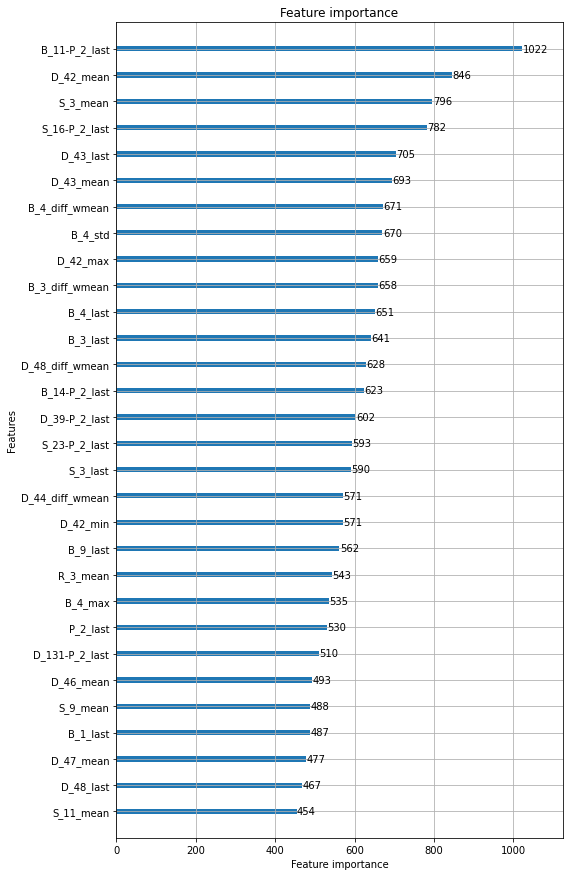

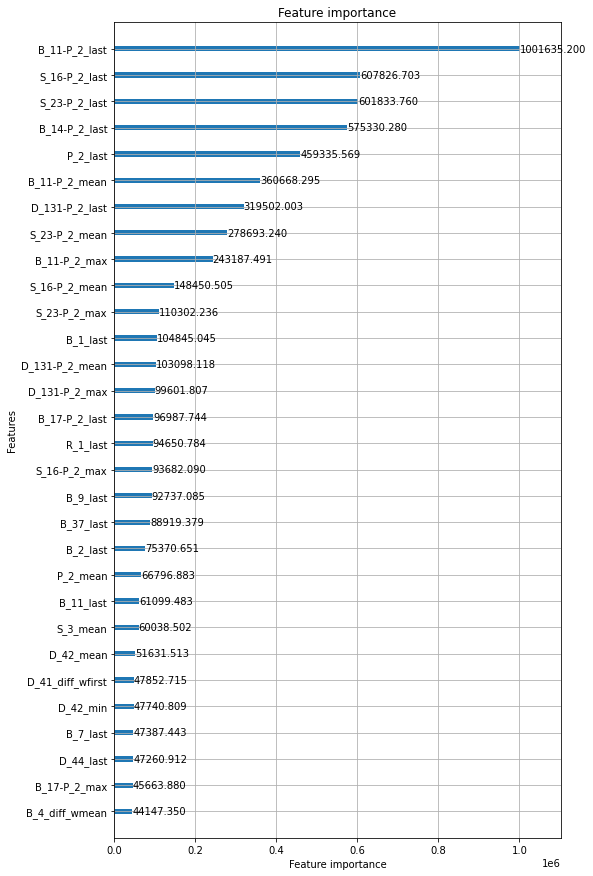

Training time: 160.4176261941592 min.
OOF recall_at4: 0.6675699330124213
OOF normalized_gini: 0.9254643433458989
OOF competition metric: 0.79651713817916


CPU times: user 1d 14h 56min 11s, sys: 1min 24s, total: 1d 14h 57min 35s
Wall time: 2h 40min 30s


In [12]:
%%time 

all_scalers = list()
all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))

    folds = pd.read_csv(f'../data/processed/cv{repetition}.csv', index_col="customer_ID")
    _train = pd.merge(train, folds, how="inner", left_index=True, right_index=True).reset_index(drop=True)
    
    tic = time.time()
    scalers,models,oof = train_models(_train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
          
    # oof metrics
    print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
    print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
    print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))
    
    all_scalers.append(scalers)
    all_models.append(models)
    all_oof_dfs.append(oof)
        
    oof.to_csv(OOF_PATH/f"oof-cv{repetition}.csv", index=False)
          
    del _train, folds; gc.collect()

In [13]:
results = list()

for oof in all_oof_dfs:  
    r = {
        "recall_at4": compute_recall_at4(oof.target.values, oof.pred.values),
        "gini": compute_normalized_gini(oof.target.values, oof.pred.values),
        "metric": compute_amex_metric(oof.target.values, oof.pred.values),
    }
    results.append(r)

results = pd.DataFrame(results)
display(results)

print("\nmean:")
display(results.mean(axis=0))

print("\nstd:")
display(results.std(axis=0))

,recall_at4,gini,metric
0,0.66757,0.925464,0.796517



mean:


recall_at4    0.667570
gini          0.925464
metric        0.796517
dtype: float64


std:


recall_at4   NaN
gini         NaN
metric       NaN
dtype: float64

In [14]:
del train, all_oof_dfs
gc.collect()

21

***
## make predictions and submit

In [15]:
def make_predictions(
        dataframe:pd.DataFrame, 
        input_feats:list,
        scalers:list,
        models:list,
    ) -> np.array:
    for scaler,model in zip(scalers,models):
        _dataframe = dataframe.copy()
        _dataframe[numeric_cols] = scaler.transform(_dataframe[numeric_cols])
        preds.append( model.predict(_dataframe[input_feats]) )
    return np.mean(preds, axis=0)    

In [16]:
test = pd.read_parquet("../data/processed/dsv02/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [ ]:
%%time

all_preds = list()

for repetition in range(N_REPEATS):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    scalers = all_scalers[repetition]
    models = all_models[repetition]
    
    preds = make_predictions(test, input_feats, scalers, models)
    all_preds.extend(preds)
       
    test["prediction"] = preds
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(SUB_PATH/f"submission-cv{repetition}.csv", index=False)

In [ ]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = np.mean(all_preds, axis=0)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(SUB_PATH/f"submission-all.csv", index=False)

***